## Wind Turbine Exploration

In [1]:
import numpy as np
import pandas as pd
import requests
import shapefile
from descartes import PolygonPatch
from matplotlib import pyplot as plt
import netCDF4
import os
import pycrs

### 1. USGS Wind Turbine Database
    TODO: Remove unwanted states.
### 2. USA Major Cities Dataset
    TODO: add in the estimated city size where turbines cannot be constructed. 
### 4. PADS
    TODO: Remove extra states and regions.
    TODO: Determine what the layers mean and what ones we need.

## 1. USGS Wind Turbine Database
Data retrieval method: Download

Documentation: https://eerscmap.usgs.gov/uswtdb/api-doc/

Example request response for wind turbine with 'case_id'=3038257. Response data contains turbine ID ('case_id'), rated capacity ('t_cap'), dimensions, coordinates ('xlong' and 'ylat'), and other relevant data. Calling the json() method on the response object gives a list of dictionaries, where each dictionary represents a turbine from the response.

In [2]:
def load_turbine():
    turbine_sf = shapefile.Reader('././data/Turbine_SHP/uswtdb_v3_3_20210114.shp') # Load shapefile.
    items = list()
    for record, shape in zip(turbine_sf.records(), turbine_sf.shapes()): # Prepare shipefile data for DataFrame.
        attributes = record.as_dict()
        items.append(attributes)

    turbine_df = pd.DataFrame(items)
    turbine_df.rename(columns={'xlong': 'longitude','ylat': 'latitude'}, inplace=True, errors='raise') # Rename columns.
    turbine_df = turbine_df[turbine_df['t_rd'] != -9999.0] # Remove turbines without rotor length.
    turbine_df['buffer_radius'] = (turbine_df['t_rd'] * 7) / 2 # Calcluate distance required between each wind turbine.
    return turbine_df

turbines = load_turbine()
turbines.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,retrofit,retrofit_y,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,longitude,latitude,buffer_radius
14,3060912.0,19-028065,2014-WTE-4081-OE,-9999.0,-9999.0,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,0.0,-9999.0,3.0,3.0,2017-05-13,Digital Globe,-93.513710,42.019119,437.5
15,3063321.0,19-028135,2014-WTE-4087-OE,-9999.0,-9999.0,IA,Hardin County,19083,30 MW Iowa DG Portfolio,2017.0,...,150.0,0.0,-9999.0,3.0,3.0,2017-06-20,Digital Globe,-93.367798,42.497940,437.5
16,3049500.0,19-028030,2014-WTE-4080-OE,-9999.0,-9999.0,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,0.0,-9999.0,3.0,3.0,2017-05-13,Digital Globe,-93.515892,42.016373,437.5
17,3063269.0,19-028130,2016-WTE-5934-OE,-9999.0,-9999.0,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,0.0,-9999.0,3.0,3.0,2017-07-23,Digital Globe,-93.632835,41.882477,437.5
18,3053390.0,19-028015,2015-WTE-6386-OE,-9999.0,-9999.0,IA,Boone County,19015,30 MW Iowa DG Portfolio,2017.0,...,150.0,0.0,-9999.0,3.0,3.0,2017-06-01,Digital Globe,-93.700424,41.977608,437.5


## 2. USA Major Cities Dataset
Data retrieval method:

Data file - CSV download (data/USA_Major_Cities.csv)
Geographic data - Shapefile download (data/USA_Major_Cities_SHP/)
Documentation: https://hub.arcgis.com/datasets/esri::usa-major-cities

Calculate Radius where Turbines cannot be constructed: https://www.census.gov/newsroom/press-releases/2015/cb15-33.html#:~:text=The%20average%20population%20density%20for,increases%20with%20city%20population%20size.

In [3]:
def load_cities():
    city_sf = shapefile.Reader('././data/USA_Major_Cities_SHP/0c5a2fa1-3463-4fc7-99e5-e206023a7e682020313-1-nmlntc.mln9c.shp')
    items = list()
    for record, shape in zip(city_sf.records(), city_sf.shapes()):
        attributes = record.as_dict()
        attributes['latitude'] = shape.points[0][1]
        attributes['longitude'] = shape.points[0][0]
        items.append(attributes)

    city_df = pd.DataFrame(items)
    return city_df

cities = load_cities()
cities.head()

,FID,NAME,CLASS,ST,STFIPS,PLACEFIPS,CAPITAL,POP_CLASS,POPULATION,POP2010,...,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,latitude,longitude
0,1,Ammon,city,ID,16,1601990,,6,15181,13816,...,106,335,3352,3.61,4747,271,3205,1271,43.475792,-111.954103
1,2,Blackfoot,city,ID,16,1607840,,6,11946,11899,...,174,381,2958,3.31,4547,318,2788,1441,43.193937,-112.345567
2,3,Boise City,city,ID,16,1608830,State,8,225405,205671,...,2414,5919,50647,2.97,92700,6996,52345,33359,43.599015,-116.230110
3,4,Burley,city,ID,16,1611260,,6,10727,10345,...,139,358,2499,3.37,3885,241,2183,1461,42.536741,-113.793293
4,5,Caldwell,city,ID,16,1612250,,7,53942,46237,...,686,1755,10776,3.51,16323,1428,9699,5196,43.661626,-116.685619


## 3. U.S. Census Cartographic Boundary Dataset

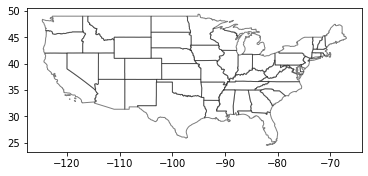

In [4]:
def load_states():
    states_sf = shapefile.Reader('././data/US_State_Boundaries_SHP/cb_2018_us_state_20m.shp')
    pass_states = [7, 25, 48] # Removes Puerto Rico, Alaska, and Hawaii
    fig = plt.figure() 
    for state in range(52):
        if state not in pass_states:
            poly = states_sf.shape(state).__geo_interface__
            ax = fig.gca() 
            ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))
            ax.axis('scaled')
    return plt

states_plt = load_states()
states_plt.rcParams['figure.figsize'] = [30, 20]
states_plt.show()

## 4. NOAA U.S. Annual Wind Speed Dataset
NetCDF files containing 2020 wind speed data.

Data retrieval:

U-wind or east-west wind component (test file: data/uwnd.sig995.2020.nc)
V-wind or north-south wind component (test file: data/vwnd.sig995.2020.nc)
U- and V- wind speed data from last 10 years for analysis (data/Wind_Speed_Data/)
Documentation for netCDF4 library: https://unidata.github.io/netcdf4-python/netCDF4/index.html

Load the files:

In [73]:
f_uwind = netCDF4.Dataset('data/Annual_Wind_speed/uwnd.sig995.2020.nc')
f_vwind = netCDF4.Dataset('data/Annual_Wind_speed/vwnd.sig995.2020.nc')

The wind speed files are composed of three-dimensional arrays. The numerical elements represent the wind speed at a given longitude and latitude on a given day. The outermost elements are lists representing days, the second outermost elements are lists representing latitudes, and the elements of those lists are numbers (representing wind speed), whose index corresponds to a longitude. The structure is illustrated below.

data = [ day1, day2, ... , day_355 ] day_i = [ lat1, lat2, ... , lat73 ] lat_j = [ lon1, lon2, ... , lon144 ]

That is, data[i][j][k] is the wind speed at (lon[k], lat[j]) on day[i].

Note: There are only 355 days listed for 2020 because the data was initially downloaded on 12-22-20. The data should be re-downloaded before final analysis.

Below is a demonstration that calculates the 2020 mean U-wind speed for each latitude and longitude.

Exception: Unexpected error: Unable to find a ring sample point.

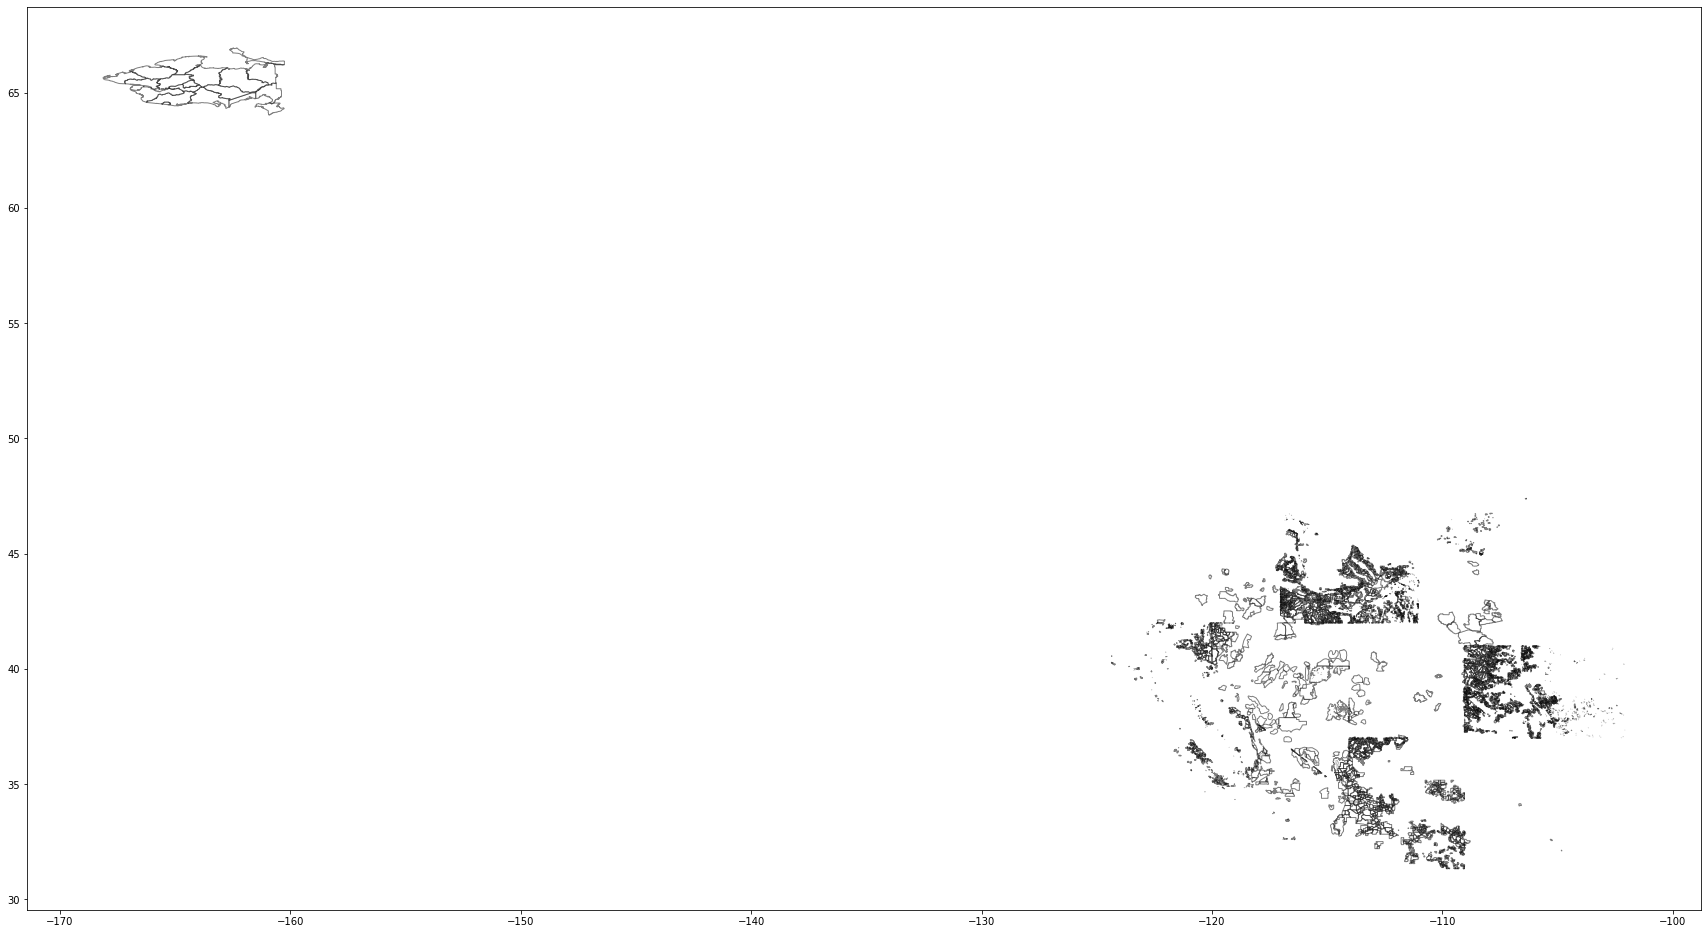

In [7]:
# states_sf = shapefile.Reader('././data/US_State_Boundaries_SHP/cb_2018_us_state_20m.shp')
# pass_states = [7, 25, 48] # Removes Puerto Rico, Alaska, and Hawaii
# fig = plt.figure() 
# for state in range(52):
#     if state not in pass_states:
#         poly = states_sf.shape(state).__geo_interface__
#         ax = fig.gca() 
#         ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))
#         ax.axis('scaled')




pad_sf = shapefile.Reader('././data/US_PADS_SHP/US_PADS_SHP_CON.shp')

fig = states_plt.figure() 

for area in range(10000):
    poly = pad_sf.shape(area).__geo_interface__
    ax = fig.gca() 
    ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))
    ax.axis('scaled')

# poly = oregon_pad.shape(1).__geo_interface__
# ax = fig.gca() 
# ax.add_patch(PolygonPatch(poly, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2 ))
# ax.axis('scaled')
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

# items = list()
# for record, shape in zip(oregon_pad.records(), oregon_pad.shapes()): # Prepare shipefile data for DataFrame.
#     attributes = record.as_dict()
#     items.append(attributes)
# oregon_df = pd.DataFrame(items)
# oregon_df
# oregon_df['INTPTLAT'][0]

In [10]:
import altair as alt

source = [
      {"year": "1875", "population": 1309},
      {"year": "1890", "population": 1558},
      {"year": "1910", "population": 4512},
      {"year": "1925", "population": 8180},
      {"year": "1933", "population": 15915},
      {"year": "1939", "population": 24824},
      {"year": "1946", "population": 28275},
      {"year": "1950", "population": 29189},
      {"year": "1964", "population": 29881},
      {"year": "1971", "population": 26007},
      {"year": "1981", "population": 24029},
      {"year": "1985", "population": 23340},
      {"year": "1989", "population": 22307},
      {"year": "1990", "population": 22087},
      {"year": "1991", "population": 22139},
      {"year": "1992", "population": 22105},
      {"year": "1993", "population": 22242},
      {"year": "1994", "population": 22801},
      {"year": "1995", "population": 24273},
      {"year": "1996", "population": 25640},
      {"year": "1997", "population": 27393},
      {"year": "1998", "population": 29505},
      {"year": "1999", "population": 32124},
      {"year": "2000", "population": 33791},
      {"year": "2001", "population": 35297},
      {"year": "2002", "population": 36179},
      {"year": "2003", "population": 36829},
      {"year": "2004", "population": 37493},
      {"year": "2005", "population": 38376},
      {"year": "2006", "population": 39008},
      {"year": "2007", "population": 39366},
      {"year": "2008", "population": 39821},
      {"year": "2009", "population": 40179},
      {"year": "2010", "population": 40511},
      {"year": "2011", "population": 40465},
      {"year": "2012", "population": 40905},
      {"year": "2013", "population": 41258},
      {"year": "2014", "population": 41777}
    ]

source2 = [{
            "start": "1933",
            "end": "1945",
            "event": "Nazi Rule"
          },
          {
            "start": "1948",
            "end": "1989",
            "event": "GDR (East Germany)"
          }]


source = alt.pd.DataFrame(source)
source2 = alt.pd.DataFrame(source2)


line = alt.Chart(source).mark_line(color='#333').encode(
    alt.X('year:T', axis=alt.Axis(format='%Y')),
    y='population'
).properties(
    width=500,
    height=300
)

point = line.mark_point(color='#333')

rect = alt.Chart(source2).mark_rect().encode(
    x='start:T',
    x2='end:T',
    color='event:N'
)
print(source2)
rect + line + point

  start   end               event
0  1933  1945           Nazi Rule
1  1948  1989  GDR (East Germany)


alt.LayerChart(...)